In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from fmow_utils import extrinsic_factors_fmow, get_fmow_boxes
from intrinsic_factors import intrinsic_factors_xywh
from metadata import MetadataBias, str2int, validate_dict

demo_classes = [
    "airport",
    # "border_checkpoint",
    "dam",
    "factory_or_powerplant",
    "hospital",
    "military_facility",
    "nuclear_powerplant",
    "oil_or_gas_facility",
    "place_of_worship",
    # "port",
    "prison",
    "stadium",
    "electric_substation",
    "road_bridge",
]
# demo_countries = ["TUR", "SYR", "IRQ"]
# demo_countries = ["RUS"]
demo_countries = ["USA"]

split_name = "dev"

In [2]:
# load precomputed table of FMOW labels and metadata
df = pd.read_pickle("../trainval_labels_factors.pkl").reset_index(drop=True)
# df["class"] = df["class"].astype("category")
# df["split"] = df.split.astype("category")
df = df[df.country_code.isin(demo_countries)]
df = df[df["class"].isin(demo_classes)]

# xywh
boxes = get_fmow_boxes(df)
img_sizes = np.column_stack((df.img_width.to_numpy(), df.img_height.to_numpy()))

# quick check for missing classes if we filter down to USA
us_classes = list(df["class"].unique())
missing = [c for c in demo_classes if c not in us_classes]

In [3]:
# gather intrinsic factors (dataset agnostic)
int_fmow, int_categorical = intrinsic_factors_xywh(boxes, img_sizes)

# gather extrinsic factors (custom to FMOW)
ext_fmow, ext_categorical = extrinsic_factors_fmow(df)

# class labels
cls_fmow = {"class": df["class"].to_numpy()}
cls_categorical = {"class": True}

In [4]:
# combine factors
factors = {**cls_fmow, **int_fmow, **ext_fmow}
is_categorical = {**cls_categorical, **int_categorical, **ext_categorical}
# match insertion order --- done in MetadataBias class as well
is_categorical = {key: is_categorical[key] for key in factors}

# map non-numeric variables to integers
orig_class = factors["class"]
factors = str2int(factors)

factor_vals = np.stack(list(factors.values()), axis=-1)
cat_mask = np.array(list(is_categorical.values()))


# make sure we have a categorical label for each factor
assert all(k in is_categorical for k in factors)
# make sure each factor has the same number of entries
validate_dict(factors)

In [5]:
md = MetadataBias(factors, is_categorical)

/workspaces/daml/prototype/metadata.py:416: RuntimeWarning: invalid value encountered in divide
  return ent_unnormalized / np.log(num_bins)


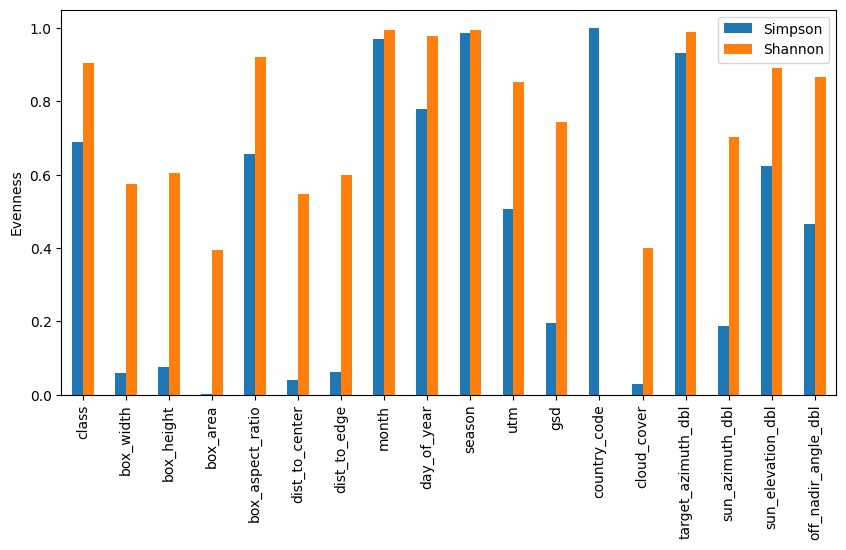

In [6]:
# Evenness independent of class label
div_simpson = md.diversity("simpson")
div_shannon = md.diversity("shannon")

plt_df = pd.DataFrame({"Simpson": div_simpson, "Shannon": div_shannon})
plt_df.plot(kind="bar", rot=90, figsize=(10, 5), ylabel="Evenness")
plt.gca().set_xticklabels(list(factors.keys()))
plt.show()

In [7]:
div_classwise_shannon = md.diversity_by_class(class_var="class", metric="shannon")
div_classwise_simpson = md.diversity_by_class(class_var="class", metric="simpson")

/workspaces/daml/prototype/metadata.py:416: RuntimeWarning: invalid value encountered in divide
  return ent_unnormalized / np.log(num_bins)


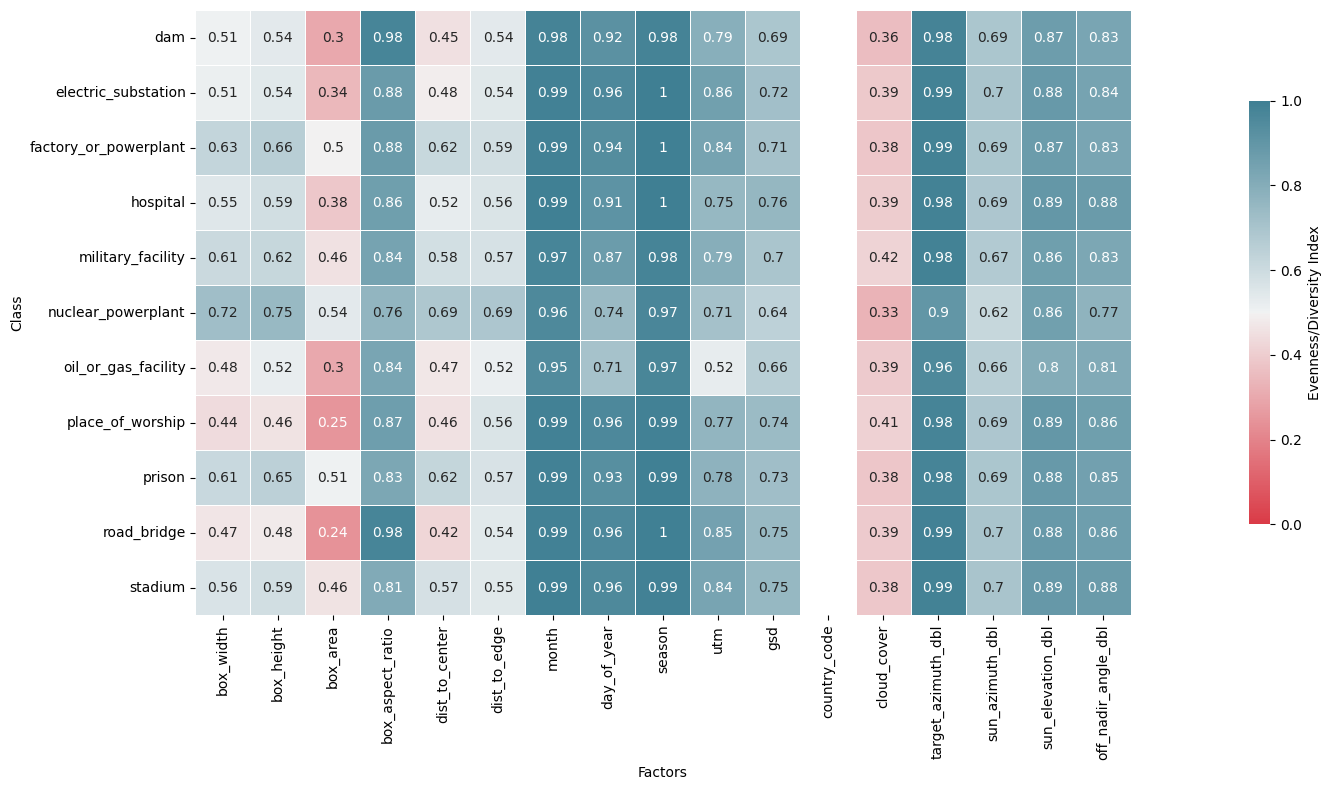

In [8]:
# factors_no_class = {k: v for k, v in factors.items() if k != "class"}

# ev = diversit(factors["class"], factors_no_class, cat_mask, metric="simpson")

classes, _ = np.unique(orig_class, return_inverse=True)

# plot
f, ax = plt.subplots(figsize=(24, 8))
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns_plot = sns.heatmap(
    div_classwise_shannon,
    cmap=cmap,
    vmin=0,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7, "label": "Evenness/Diversity Index"},
    xticklabels=[n for n in md.names if n != "class"],
    yticklabels=classes,
    annot=True,
)
plt.xlabel("Factors")
plt.ylabel("Class")
plt.title("")
plt.tight_layout()

In [9]:
# demo data
import json

#  could choose simpson OR shannon instead of both
diversity_data = {
    "simpson": div_simpson.tolist(),
    "shannon": div_shannon.tolist(),
    "factors": md.names,
}
diversity_classwise = {
    "classwise_simpson": div_classwise_simpson.tolist(),
    "classwise_shannon": div_classwise_shannon.tolist(),
    "classes": classes.tolist(),
    "factors": md.names,
}


with open(f"{split_name}_diversity_data.json", "w") as fp:
    json.dump(diversity_data, fp)
with open(f"{split_name}_diversity_classwise.json", "w") as fp:
    json.dump(diversity_classwise, fp)

# diversity_rollup = np.sum(np.array(diversity_data["shannon"]) < 0.5)